In [1]:
import torch
import gc
import torchvision.models as models
import torch.nn as nn

import dataloader
import trainer
import visualizer

## Main Functions

Auto-reload files imported to the notebook

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Device:', device)

Device: cuda


For torch dataloader to use num_workers > 0, it relies on python multiprocessing, which in windows have deadlock issues, unless the instantiation is in a .py module and the code that invokes it is wrapped inside a \__main__ section.
https://github.com/pytorch/pytorch/issues/51344

torch.Size([3, 480, 640]) torch.Size([1, 480, 640])


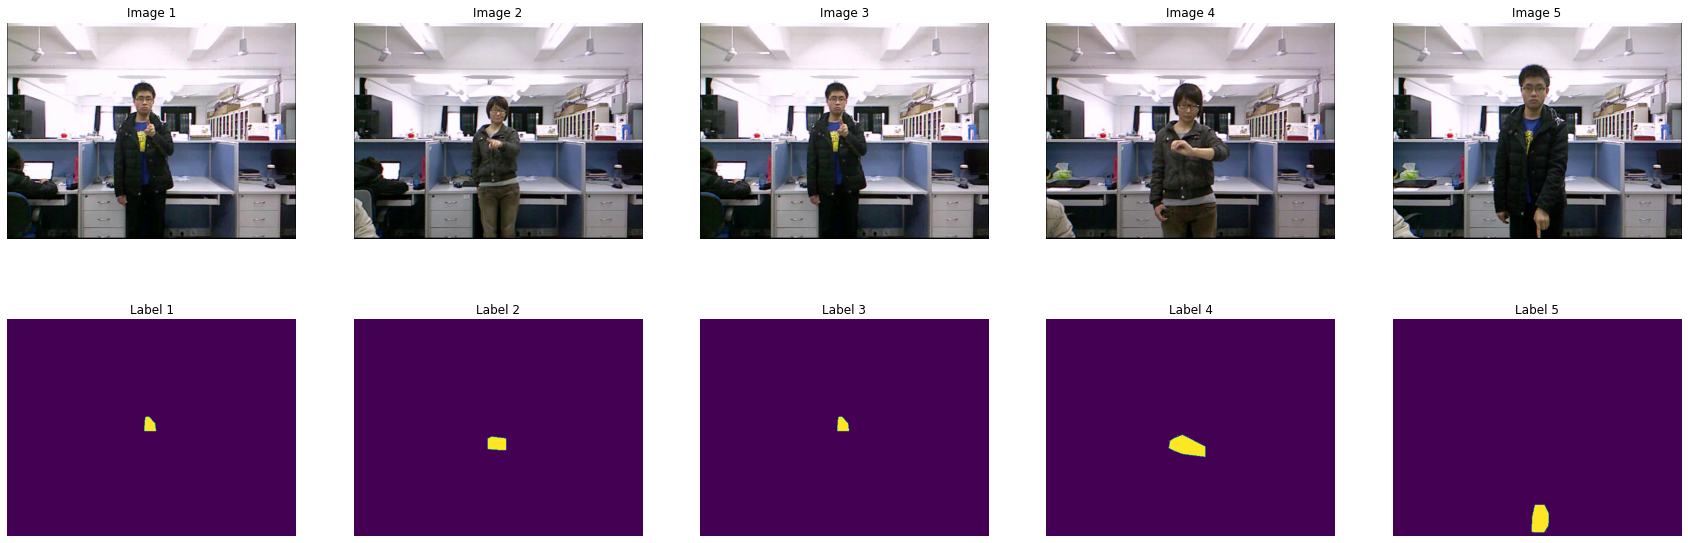

In [4]:
if __name__ == '__main__':
    loader_train, loader_val, loader_test = dataloader.main(batch_size=10, num_workers=4, use_dep8=True)

In [5]:
# Free cuda memory
# Reference: https://discuss.pytorch.org/t/how-to-debug-causes-of-gpu-memory-leaks/6741/13
def freemem():
    for obj in gc.get_objects():
        if torch.is_tensor(obj) and torch.is_tensor(obj.data):
            del obj
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
    gc.collect()

## Resnet18 Without tiles and utilizing the full dataset

Here we import the resnet18 model with pretrained weights. This gives us some good starting weights so that we don't have to train the model from scratch.

In [6]:
resnet18_notile_full = models.resnet18(pretrained=True)

From there, we replace the last layer to work with the tiles format rather than Resnet's standard classification. Lastly, we freeze all of the layers except for the newly added layer so that it can be trained individually

In [7]:
x, y = next(iter(loader_val))

resnet18_notile_full.fc = nn.Linear(512, x.shape[-2]*x.shape[-1])
print(resnet18_notile_full.fc)

Linear(in_features=512, out_features=307200, bias=True)


##### NOTE: If you want to load the saved model then skip then section and run from the Visualize Model section

In [8]:
for param in resnet18_notile_full.parameters():
    param.require_grad = False
resnet18_notile_full.fc.requires_grad_(True)

Linear(in_features=512, out_features=307200, bias=True)

Now let's train the model!

In [9]:
freemem()

C:\Users\EthanRuoff\anaconda3\envs\cv\lib\site-packages\torch\distributed\distributed_c10d.py:170: UserWarning: torch.distributed.reduce_op is deprecated, please use torch.distributed.ReduceOp instead
  warnings.warn(


In [10]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Device:', device)
resnet18_notile_full = resnet18_notile_full.to(device)
trainer.train(resnet18_notile_full, loader_train, loader_val, lr=1e-4, device=device, num_epochs=100, patience=10, pos_weight=[5])

Device: cuda
Training epoch 1 batch 1250/2500, train loss = 0.298668, train acc = 0.940191, recall = 0.617173, precision = 0.066701


d:\Documents\Fingertip-Finder\dataloader.py:117: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  chull = cv.convexHull(np.vstack(cnts[i] for i in range(len(cnts))), False)


validation metrics at epoch 1 batch 1250: val loss = 0.143319, val acc = 0.925586, val recall = 0.737899, val precision = 0.059126

validation metrics at epoch 1 batch 2500: val loss = 0.296876, val acc = 0.926177, val recall = 0.785124, val precision = 0.065451
current_patience = 9
Epoch 1/100 train loss = 0.192959, train acc = 0.931698, val loss = 0.296876, val acc = 0.926177
Training epoch 2 batch 1250/2500, train loss = 0.146292, train acc = 0.965755, recall = 0.500018, precision = 0.102355
validation metrics at epoch 2 batch 1250: val loss = 0.114777, val acc = 0.981962, val recall = 0.351357, val precision = 0.135867

validation metrics at epoch 2 batch 2500: val loss = 0.069381, val acc = 0.991343, val recall = 0.294567, val precision = 0.304041
Epoch 2/100 train loss = 0.113419, train acc = 0.977362, val loss = 0.069381, val acc = 0.991343
Training epoch 3 batch 1250/2500, train loss = 0.062659, train acc = 0.992261, recall = 0.334183, precision = 0.369189
validation metrics at

([0.14331865684284517,
  0.2968758241335551,
  0.11477680996060372,
  0.06938090754052004,
  0.05730949961890777,
  0.04284195777028799,
  0.03344457228978475,
  0.02565501457701127,
  0.021492671575397252,
  0.017196830436587332,
  0.01657518348346154,
  0.015542283542454243,
  0.014241819344460964,
  0.013760716548810403,
  0.01300946505740285,
  0.012900063004344701,
  0.012459029483919342,
  0.012441182713955641,
  0.012431014388178785,
  0.011103385236735146,
  0.011155362324789166,
  0.011219066542883713,
  0.01064988464427491,
  0.011043807795892159,
  0.01034734862856567,
  0.010153924360250434,
  0.011477362019941212,
  0.01021677825289468,
  0.009933302613596122,
  0.009963279034321508,
  0.00980106753607591,
  0.010062651596963406,
  0.010222025150433182,
  0.00976609424377481,
  0.0098147544482102,
  0.009758596845592061,
  0.009734692675992846,
  0.009740005703642965,
  0.009625967312604188,
  0.009568686091030638,
  0.009646530064443748,
  0.009292770515506466,
  0.009429

Unfreeze the layers and train with the fully unfrozen model

In [11]:
for param in resnet18_notile_full.parameters():
    param.require_grad = True
trainer.train(resnet18_notile_full, loader_train, loader_val, lr=1e-4, device=device, num_epochs=100, patience=10)

torch.save(resnet18_notile_full.state_dict(), 'saved_models/resnet18_notile_full.model')

Training epoch 1 batch 1250/2500, train loss = 0.003567, train acc = 0.998470, recall = 0.869091, precision = 0.884782
validation metrics at epoch 1 batch 1250: val loss = 0.004318, val acc = 0.998191, val recall = 0.880224, val precision = 0.846035

validation metrics at epoch 1 batch 2500: val loss = 0.004325, val acc = 0.998174, val recall = 0.896069, val precision = 0.834454
current_patience = 9
Epoch 1/100 train loss = 0.003580, train acc = 0.998464, val loss = 0.004325, val acc = 0.998174
Training epoch 2 batch 1250/2500, train loss = 0.003431, train acc = 0.998535, recall = 0.873277, precision = 0.891713
validation metrics at epoch 2 batch 1250: val loss = 0.004212, val acc = 0.998255, val recall = 0.887308, val precision = 0.849084

validation metrics at epoch 2 batch 2500: val loss = 0.004125, val acc = 0.998285, val recall = 0.876969, val precision = 0.861036
Epoch 2/100 train loss = 0.003458, train acc = 0.998521, val loss = 0.004125, val acc = 0.998285
Training epoch 3 batc

## Model Visualizations

In [12]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Device:', device)

Device: cuda


Load the model if you dont want to train it

In [13]:
# resnet18_notile_full.load_state_dict(torch.load('saved_models/resnet18_notile_full.model', map_location=torch.device(device)))
# resnet18_notile_full = resnet18_notile_full.to(device)

Accuracy = 99.83288049697876%
Precision = 83.08445811271667%
Recall = 91.72091484069824%


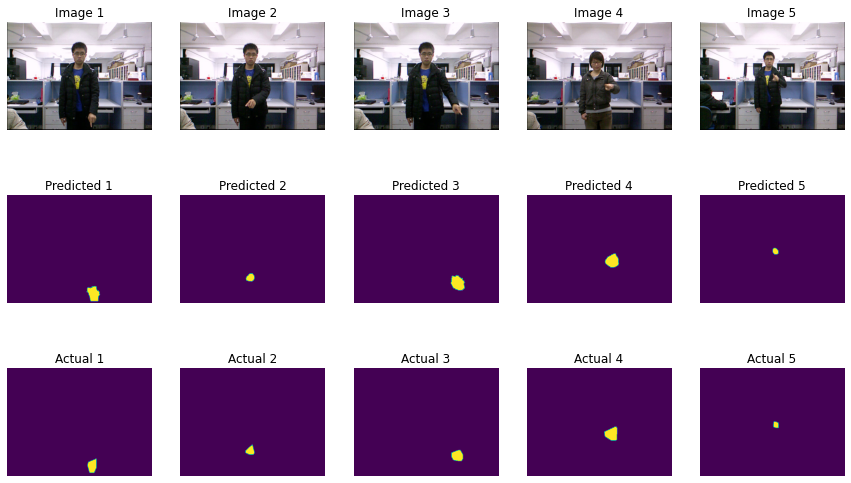

In [14]:
visualizer.visualize_model_output(loader_test, resnet18_notile_full, device=device)

In [15]:
freemem()

In [ ]:
x, y = next(iter(loader_val))

resnet18_notile_full_2 = models.resnet18(pretrained=True)

resnet18_notile_full_2.fc = nn.Linear(512, x.shape[-2]*x.shape[-1])
print(resnet18_notile_full_2.fc)

for param in resnet18_notile_full_2.parameters():
    param.require_grad = False
resnet18_notile_full_2.fc.requires_grad_(True)

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Device:', device)
resnet18_notile_full_2 = resnet18_notile_full_2.to(device)
trainer.train(resnet18_notile_full_2, loader_train, loader_val, lr=1e-4, device=device, num_epochs=100, patience=10)

for param in resnet18_notile_full_2.parameters():
    param.require_grad = True
trainer.train(resnet18_notile_full_2, loader_train, loader_val, lr=1e-4, device=device, num_epochs=100, patience=10)

torch.save(resnet18_notile_full_2.state_dict(), 'saved_models/resnet18_notile_full_2.model')

Accuracy = 99.80127811431885%
Precision = 71.5584933757782%
Recall = 75.75492262840271%


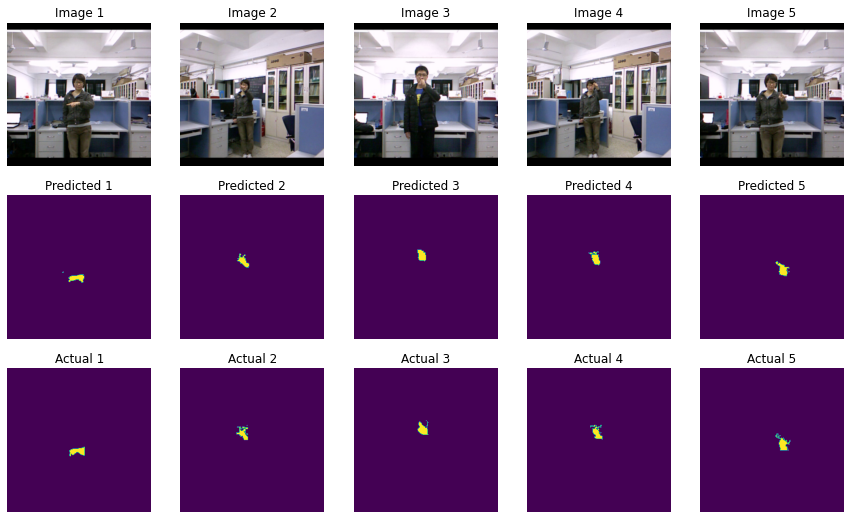

In [ ]:
visualizer.visualize_model_output(loader_test, resnet18_notile_full_2, device=device)